In [1]:
import numpy as np
import torch
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset, get_human_timeseries_dataset
from mcspace.utils import get_device, pickle_load, pickle_save, get_summary_results, MODEL_FILE, DATA_FILE
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mcspace.dataset import DataSet
import pandas as pd
import ete3
from Bio import SeqIO, Phylo

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import scipy.cluster.hierarchy as sch

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
basepath = Path("./")
rootpath = Path("../../")
datapath = rootpath / "paper" / "datasets"

outpath = basepath / "main_figures"
outpath.mkdir(exist_ok=True, parents=True)

In [4]:
human_treepath = datapath / "human_experiments" / "human_otus_tree" / "output"
human_treefile = "newick_tree_query_reads.nhx"

mouse_treepath = datapath / "mouse_experiments" / "output"
mouse_treefile = "newick_tree_query_reads.nhx"

# Load datasets

## human

In [5]:
human_reads, human_num_otus, human_times, human_subjects, human_dataset = get_human_timeseries_dataset(rootpath=datapath)

temp_taxonomy = human_dataset.get_taxonomy() 
# updated taxonomy
humanpath = datapath / "human_experiments"
humantax = pd.read_csv(humanpath / "gappa_taxonomy" / "human_taxonomy.csv", index_col=0)
human_taxonomy = humantax.loc[temp_taxonomy.index,:]

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\dataset.py:21: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  self._long_data = pd.read_csv(reads)


## mouse

In [6]:
mouse_reads, mouse_num_otus, mouse_times, mouse_subjects, mouse_dataset = get_mouse_diet_perturbations_dataset(rootpath=datapath)

temp_taxonomy = mouse_dataset.get_taxonomy() 
# updated taxonomy
mousepath = datapath / "mouse_experiments"
mousetax = pd.read_csv(mousepath / "taxonomy" / "taxonomy.csv", index_col=0)
mouse_taxonomy = mousetax.loc[temp_taxonomy.index,:]

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\dataset.py:23: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  self._long_data = pd.read_csv(reads, compression='gzip')


# Get plot data

## pool subjects

In [7]:
def pool_subjects(reads,times,subjects):
    pooled_data = {}
    for t in times:
        all_particles = None
        for s in subjects:
            if all_particles is None:
                all_particles = reads[t][s]
            else:
                all_particles = np.concatenate([all_particles, reads[t][s]], axis=0)
        pooled_data[t] = all_particles
    return pooled_data

In [8]:
human_pooled = pool_subjects(human_reads, human_times, human_subjects)
mouse_pooled = pool_subjects(mouse_reads, mouse_times, mouse_subjects)

## get relative abundances and cluster particles; otu distributions

In [29]:
# human data
human_clustered = {}
human_otudist = {}
for t in human_times:
    counts = human_pooled[t]
    ra = counts/(counts.sum(axis=1,keepdims=True))
    notuspp = (ra>0.005).sum(axis=1)
    human_otudist[t] = notuspp
    logra = np.log10(ra + 1e-10)
    data_matrix=logra.T
    col_dist = sch.linkage(data_matrix.T, method='ward')
    col_order = sch.leaves_list(col_dist)
    ordered_data_matrix = data_matrix[:, col_order]
    human_clustered[t] = pd.DataFrame(ordered_data_matrix, index=human_taxonomy.index)
    
# mouse data
mouse_clustered = {}
mouse_otudist = {}
for t in mouse_times:
    counts = mouse_pooled[t]
    ra = counts/(counts.sum(axis=1,keepdims=True))
    notuspp = (ra>0.005).sum(axis=1)
    mouse_otudist[t] = notuspp
    logra = np.log10(ra + 1e-10)
    data_matrix=logra.T
    col_dist = sch.linkage(data_matrix.T, method='ward')
    col_order = sch.leaves_list(col_dist)
    ordered_data_matrix = data_matrix[:, col_order]
    mouse_clustered[t] = pd.DataFrame(ordered_data_matrix, index=mouse_taxonomy.index)

# Render figure

In [88]:
def get_pruned_tree(treepath, treefile, taxonomy, temppath=Path("./_tmp"), upper=False):
    tree = ete3.Tree((treepath / treefile).as_posix())
    print("original tree size:", len(tree))
    taxaids = list(taxonomy.index)
    if upper:
        taxaids = [idx.upper() for idx in taxaids]
    tree.prune(taxaids, True)
    print("pruned tree size:", len(tree))
    
    treeout = "tree.nhx"
    temppath.mkdir(exist_ok=True, parents=True)
    tree.write(outfile=(temppath / treeout).as_posix())
    phylo_tree = Phylo.read(temppath / treeout, format='newick')
    return phylo_tree


def get_lowest_level(otu, taxonomy):
    taxonomies = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']
    for level in taxonomies:
        levelid = taxonomy.loc[otu,level]
        if levelid != 'na':
            return levelid, level
        

def plot_phylo_tree(ax, tree, taxonomy, fontsize=16, text_len=41):            
    TEXT_LEN=text_len
    prefix_taxa = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****',
                   'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}

    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    taxa_order = []

    for text in ax.texts:
        taxonname = str(text._text).replace(' ','').capitalize()
        otu_name = taxonname
        taxa_order.append(otu_name)
        name, level = get_lowest_level(otu_name, taxonomy)
        prefix = prefix_taxa[level]
        taxonname = ' ' + prefix + ' ' + name + ' ' + otu_name.upper()
        text._text = taxonname
        text._text = text._text + '- ' * (TEXT_LEN - len(text._text))
        text.set_fontsize(fontsize)
        if (level == 'Species') or (level == 'Genus') or (level == 'Family'):
            text.set_fontstyle('italic')
    ax = remove_border(ax)
    return ax, taxa_order


def add_border(ax, color='black'):
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color(color)
    return ax


def remove_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax


def box_to_ell_axes(ax):
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    return ax 

#### might want to resize so tree same width in both...; is also somewhat deceptive human vs mouse, with widths...

In [84]:
tree_width = 0.1
tree_gap = 0.1

part_width = 1.0 - tree_width - tree_gap

human_widths = [tree_width, tree_gap]

total_human_particles = 0
for t in human_times:
    total_human_particles += human_pooled[t].shape[0]

for t in human_times:    
    human_widths.append(part_width*human_pooled[t].shape[0]/total_human_particles)
    
mouse_widths = [tree_width, tree_gap]
total_mouse_particles = 0
for t in mouse_times:
    total_mouse_particles += mouse_pooled[t].shape[0]

for t in mouse_times:    
    mouse_widths.append(part_width*mouse_pooled[t].shape[0]/total_mouse_particles)
    
vmin=-3
vmax=0
cmap = plt.get_cmap('Greys')
cmap.set_under('white')

total_num_otus = human_num_otus + mouse_num_otus
diets = ['S1', 'HF', 'S2', 'HFHF', 'S3', 'LP', 'S4']

In [63]:
print(np.array(human_widths).sum())
print(np.array(mouse_widths).sum())

1.0
1.0


In [92]:
otudistheight = 0.15
leftoverheight = 1.0 - 2*otudistheight
hheight = (human_num_otus/total_num_otus)*leftoverheight
mheight = (mouse_num_otus/total_num_otus)*leftoverheight
height_ratios=[hheight, otudistheight, mheight, otudistheight]

original tree size: 3923
pruned tree size: 58
original tree size: 1406
pruned tree size: 74


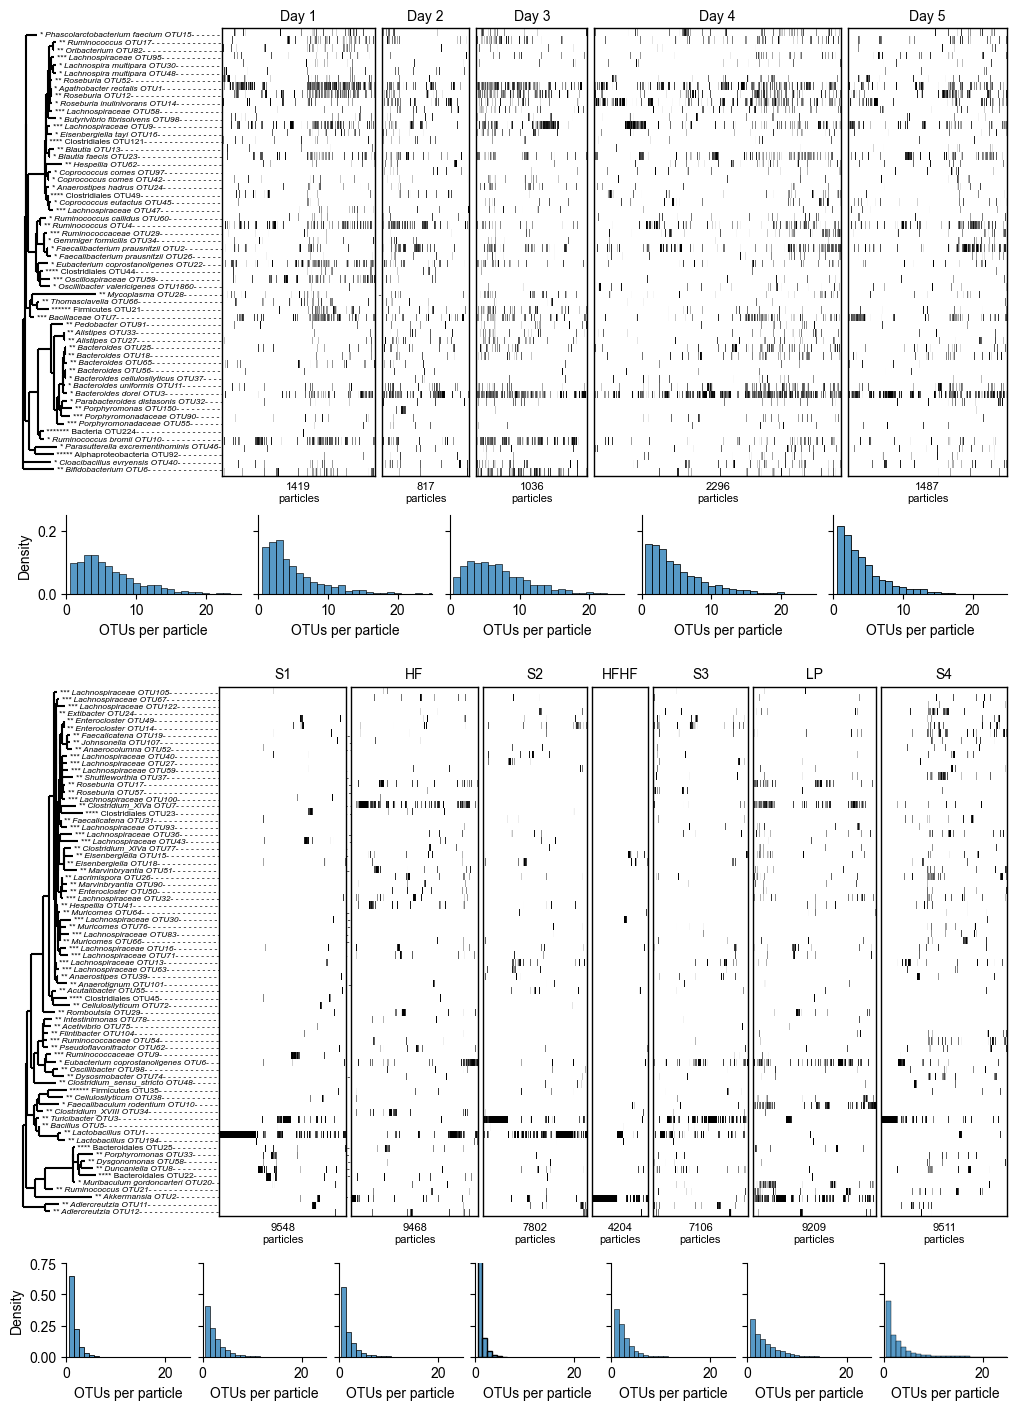

In [106]:
tree_fontsize = 6
label_fontsize = 8
title_fontsize = 10
tree_text_len = 60

scale = 1.5
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=2, ncols=1, 
                      height_ratios=[hheight + otudistheight, mheight + otudistheight],
                    hspace=0.15)
gs_human = gs[0,0].subgridspec(2,2,
                               height_ratios=[1.0-otudistheight, otudistheight], 
                               width_ratios=[1,20],
                               wspace=0,
                               hspace=0.15)
gs_mouse = gs[1,0].subgridspec(2,2,
                               height_ratios=[1.0-otudistheight, otudistheight], 
                               width_ratios=[1,20],
                               wspace=0,
                               hspace=0.15)

# human particle axes
gs_hpart = gs_human[0,:].subgridspec(1,len(human_times)+2, width_ratios=human_widths, wspace=0.05)
ax_htree = fig.add_subplot(gs_hpart[0,0])
ax_h = []
for i in range(len(human_times)):
    ax_h.append(fig.add_subplot(gs_hpart[0,i+2]))

# human otu dist
gs_hotu = gs_human[1,1].subgridspec(1, len(human_times), wspace=0.1)
ax_ho = []
for i in range(len(human_times)):
    ax_ho.append(fig.add_subplot(gs_hotu[0,i]))

# mouse particle axes
gs_mpart = gs_mouse[0,:].subgridspec(1,len(mouse_times)+2, width_ratios=mouse_widths, wspace=0.05)
ax_mtree = fig.add_subplot(gs_mpart[0,0])
ax_m = []
for i in range(len(mouse_times)):
    ax_m.append(fig.add_subplot(gs_mpart[0,i+2]))

# mouse otu dist
gs_motu = gs_mouse[1,1].subgridspec(1, len(mouse_times), wspace=0.1)
ax_mo = []
for i in range(len(mouse_times)):
    ax_mo.append(fig.add_subplot(gs_motu[0,i]))
    
    

# plot human particle data...
# plot tree
taxa = human_taxonomy.reset_index().set_index("Otu")
human_tree = get_pruned_tree(human_treepath, human_treefile, taxa, temppath=Path("./_tmp_sub"), upper=True)
ax_htree, human_otu_order = plot_phylo_tree(ax_htree, human_tree, human_taxonomy, 
                                            fontsize=tree_fontsize, text_len=tree_text_len)

# plot particle data
for i,t in enumerate(human_times):
    tempdata = human_clustered[t]
    ax_h[i]=sns.heatmap(tempdata.loc[human_otu_order,:], cmap=cmap, vmin=vmin, vmax=vmax,
                        cbar=False,ax=ax_h[i], xticklabels=False, yticklabels=False)
    ax_h[i]=add_border(ax_h[i])
    ax_h[i].set_title(f"Day {t}", fontsize=title_fontsize)
    ax_h[i].set_ylabel("")
    npart = tempdata.shape[1]
    ax_h[i].set_xlabel(f"{npart}\nparticles", fontsize=label_fontsize)
    
# plot otu distributions
for i,t in enumerate(human_times):
    ax_ho[i]=sns.histplot(human_otudist[t], discrete=True, stat='probability', ax=ax_ho[i])
    ax_ho[i].set_xlim(0,25)
    ax_ho[i].set_ylim(0,0.25)
    ax_ho[i]=box_to_ell_axes(ax_ho[i])
    ax_ho[i].set_xlabel("OTUs per particle")
    if i > 0:
        ax_ho[i].set_ylabel("")
        ax_ho[i].set_yticklabels("")
    else:
        ax_ho[i].set_ylabel("Density")
    
    
# plot mouse particle data...
# plot tree
taxa = mouse_taxonomy.reset_index().set_index("Otu")
mouse_tree = get_pruned_tree(mouse_treepath, mouse_treefile, taxa, temppath=Path("./_tmp_sub"), upper=False)
ax_mtree, mouse_otu_order = plot_phylo_tree(ax_mtree, mouse_tree, mouse_taxonomy, 
                                            fontsize=tree_fontsize, text_len=tree_text_len)

# plot particle data
for i,t in enumerate(mouse_times):
    tempdata = mouse_clustered[t]
    ax_m[i]=sns.heatmap(tempdata.loc[mouse_otu_order,:], cmap=cmap, vmin=vmin, vmax=vmax,
                        cbar=False,ax=ax_m[i], xticklabels=False, yticklabels=False)
    ax_m[i]=add_border(ax_m[i])
    ax_m[i].set_title(f"{diets[i]}", fontsize=title_fontsize)
    ax_m[i].set_ylabel("")
    npart = tempdata.shape[1]
    ax_m[i].set_xlabel(f"{npart}\nparticles", fontsize=label_fontsize)
    
# plot otu distributions
for i,t in enumerate(mouse_times):
    ax_mo[i]=sns.histplot(mouse_otudist[t], discrete=True, stat='probability', ax=ax_mo[i])
    ax_mo[i].set_xlim(0,25)
    ax_mo[i].set_ylim(0,0.75)
    ax_mo[i]=box_to_ell_axes(ax_mo[i])
    ax_mo[i].set_xlabel("OTUs per particle")
    if i > 0:
        ax_mo[i].set_ylabel("")
        ax_mo[i].set_yticklabels("")
    else:
        ax_mo[i].set_ylabel("Density")
# plt.savefig(outpath / "figure_full_dataset.svg", bbox_inches="tight")
# plt.savefig(outpath / "figure_full_dataset.pdf", bbox_inches="tight")
plt.savefig(outpath / "figure_full_dataset.png", bbox_inches="tight")

### plot colorbar legend

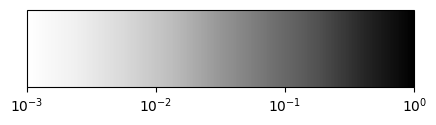

In [103]:
fig, ax = plt.subplots(figsize=(5,1))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
ax=mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
ax.ax.set_xticks([0,-1,-2, -3])
ax.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$'])
plt.savefig(outpath / "legend_figure_full_dataset.svg", bbox_inches="tight")

In [104]:
outpath

WindowsPath('main_figures')

## plot otu distributions

5.0
4.0
6.0
4.0
3.0


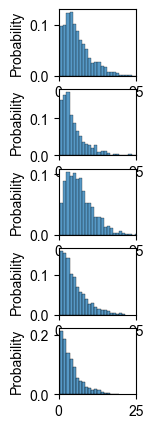

In [81]:
fig, ax = plt.subplots(figsize=(1,len(human_times)), nrows=len(human_times))
for i,t in enumerate(human_times):
    ax[i]=sns.histplot(human_otudist[t], discrete=True, stat='probability', ax=ax[i])
    print(np.median(human_otudist[t]))
    ax[i].set_xlim(0,25)

1.0
2.0
1.0
1.0
2.0
3.0
2.0


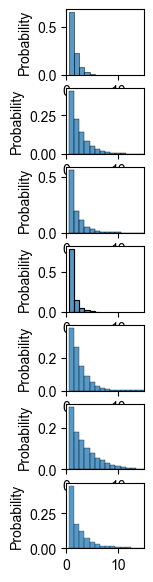

In [80]:
fig, ax = plt.subplots(figsize=(1,len(mouse_times)), nrows=len(mouse_times))
for i,t in enumerate(mouse_times):
    ax[i]=sns.histplot(mouse_otudist[t], discrete=True, stat='probability', ax=ax[i])
    print(np.median(mouse_otudist[t]))
    ax[i].set_xlim(0,15)